# **Analysis of models trained on LeftRightMNIST classification**
Author: patrick.mccarthy@dtc.ox.ac.uk

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from pathlib import Path
import pickle
import glob
import os
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
from scipy.special import softmax
from scipy.linalg import svd
from sklearn import svm
from sklearn.decomposition import KernelPCA, PCA
from scipy.stats import entropy

from thalamocortex.models import CTCNet
from thalamocortex.utils import create_data_loaders, activation_hook, get_neuron_weights, plot_receptive_field

In [29]:
plt.rcParams['legend.fontsize'] = 8  
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['axes.facecolor'] = 'w'  
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['savefig.bbox'] = 'tight'  
plt.rcParams['savefig.pad_inches'] = 0.1 
plt.rcParams['axes.titlesize'] = 10  
plt.rcParams['figure.titlesize'] = 10  

In [30]:
save_path = "/Users/patmccarthy/Documents/phd/rotation1/results_11_03_25/leftrightmnist"

Load results

In [31]:
results_paths = {
    "no feedback": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_feedforward_leftrightmnist/2_CTCNet_TC_none",
    "driver": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_driver_leftrightmnist/2_CTCNet_TC_add_reciprocal_readout",
    "modulator": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_mod1_leftrightmnist/2_CTCNet_TC_multi_pre_activation_reciprocal",
}

In [32]:
# load models, learning stats, results 
results = {}
for model_name, path in results_paths.items():
    
    # NOTE: note loading trained models because can instantiate from final weights

    # hyperparameters
    with open(Path(f"{path}", "hyperparams.pkl"), "rb") as handle:
        hp = pickle.load(handle)

    # learning progress
    with open(Path(f"{path}", "learning.pkl"), "rb") as handle:
        learning = pickle.load(handle)

    # store results and params in dict
    results[model_name] = {"val_losses": learning["val_losses"],
                           "train_losses": learning["train_losses"],
                           "val_topk_accs": learning["val_topk_accs"],
                           "train_topk_accs": learning["train_topk_accs"],
                           "train_time": learning["train_time"],
                           "state_dicts": learning["state_dicts"],
                           "hyperparams": hp}
    
    # get number of epochs to train for
    n_epochs = len(learning["train_topk_accs"])

    if model_name in ["no feedback", "driver", "modulator"]:
        results[model_name]["val_losses"].pop(0)
        results[model_name]["val_topk_accs"].pop(0)
        results[model_name]["state_dicts"].pop(0)

    else:
        epoch_range = np.arange(0, n_epochs)

    # get top-1 accuracies in more convenient form for plotting
    train_top1_accs = []
    val_top1_accs = []
    
    # store training info
    for epoch in np.arange(n_epochs):
        train_top1_accs.append(learning["train_topk_accs"][epoch][1])
        val_top1_accs.append(learning["val_topk_accs"][epoch][1])
    results[model_name]["train_top1_accs"] = np.array(train_top1_accs)
    results[model_name]["val_top1_accs"] = np.array(val_top1_accs)
    

### **Learning progress**

In [33]:
model_plot_list = ["no feedback", "driver", "modulator"]

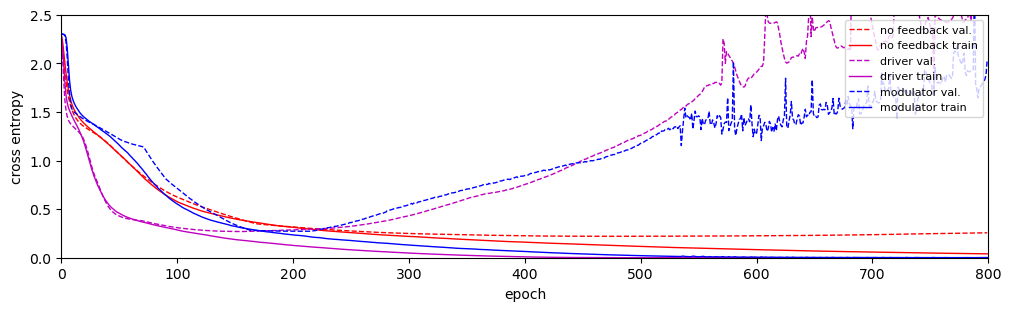

In [34]:
# loss through time
# n_epochs = len(results[model_plot_list[0]]["val_losses"])
colours = ["r", "m", "b", "o"]
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        # ax.plot(np.arange(n_epochs+1), np.median(np.array(model_results["val_losses"]), axis=-1), ls="--", linewidth=1, label=f"{model_name} val.", c=colours[models_plotted_idx-1])
        # ax.plot(1+np.arange(n_epochs), np.median(np.array(model_results["train_losses"]), axis=-1), ls="-", linewidth=1, label=f"{model_name} train", c=colours[models_plotted_idx-1])

        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["val_losses"]), axis=-1), ls="--", linewidth=1, label=f"{model_name} val.", c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["train_losses"]), axis=-1), ls="-", linewidth=1, label=f"{model_name} train", c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("cross entropy")
ax.set_xlabel("epoch")
ax.set_xlim(0, n_epochs)
ax.set_ylim(0, 2.5)
ax.legend(loc="upper right")
fig.savefig(Path(save_path, "loss_curve.png"))

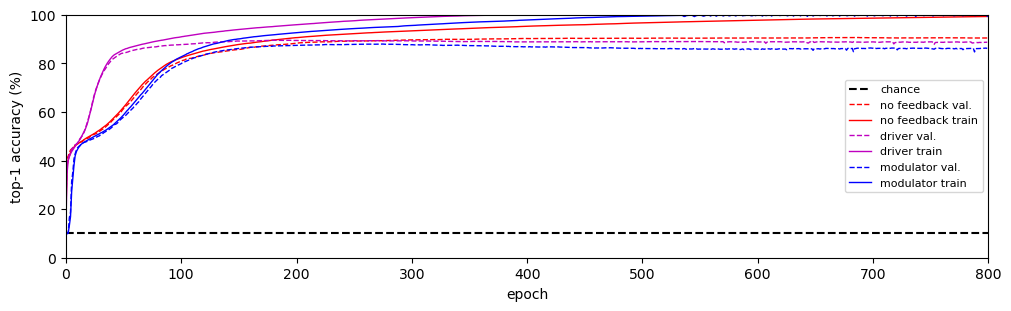

In [35]:
# accuracy through time
fig, ax = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")
ax.axhline(10, ls="--", c="k", label="chance")
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        ax.plot(np.arange(n_epochs), np.array(model_results["val_top1_accs"]) * 100,ls="--", label=f"{model_name} val.", linewidth=1, c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.array(model_results["train_top1_accs"]) * 100, ls="-", label=f"{model_name} train", linewidth=1, c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("top-1 accuracy (%)")
ax.set_xlabel("epoch")
ax.set_ylim(0, 100)
ax.set_xlim(0, n_epochs)
ax.legend(loc="center right")
fig.savefig(Path(save_path, "accuracy_curve.png"))

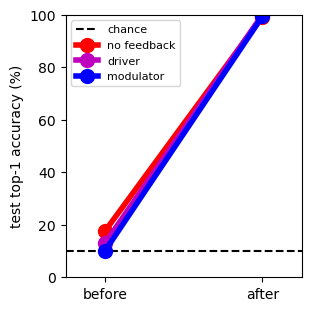

In [36]:
# accuracy before and after convergence
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.axhline(10, ls="--", c="k", label="chance")
for models_plotted_idx, (model_name, model_results) in enumerate(results.items()):
    # print(f"{models_plotted_idx}")
    if model_name in model_plot_list:
        ax.plot([0, 1], [model_results["train_top1_accs"][0] * 100, model_results["train_top1_accs"][-1] * 100], c=colours[models_plotted_idx], marker="o", markersize=10, linewidth=4, label=model_name)
ax.set_ylabel("test top-1 accuracy (%)")
ax.set_ylim(0, 100)
ax.set_xlim(-0.25, 1.25)
ax.set_xticks([0, 1])
ax.set_xticklabels(["before", "after"])
ax.legend(loc="upper left")
fig.savefig(Path(save_path, "accuracy_prepostlearning.png"))

### **Trained model analysis**

In [37]:
models_selected = ["no feedback", "driver", "modulator"]

In [38]:
# epoch of trained model weights to use 
epoch_trained = 800

Test set inference

In [39]:
# create loaders
trainset_loader, testset_loader, metadata = create_data_loaders(dataset=results[models_selected[0]]["hyperparams"]["dataset"],
                                                                norm=results[models_selected[0]]["hyperparams"]["norm"],
                                                                batch_size=32,
                                                                save_path="/Users/patmccarthy/Documents/ThalamoCortex/data")

In [64]:
# load trainset
ds_path = "/Users/patmccarthy/Documents/ThalamoCortex/data/LeftRightMNIST/test.pkl"
with open(Path(ds_path), "rb") as handle:
    dataset = pickle.load(handle)

In [67]:
dataset["X"].shape

(7002, 28, 56)

In [69]:
len(dataset["sides"])

7002

In [40]:
# load full test set
X_all = []
y_all = []
for X, y in iter(testset_loader):
    # X_all.append(X.detach().numpy()[:, 0, :, :])
    # y_all.append(y.detach().numpy()[:])
    X_all.append(X[:, :, :])
    y_all.append(y[:])
if results[models_selected[0]]["hyperparams"]["dataset"] in ["BinaryMNIST", "LeftRightMNIST"]:
    # Concatenate along the first axis (num_samples)
    X_all_arr = np.concatenate(X_all, axis=0)  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = np.concatenate(y_all, axis=0)  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)
else:
    X_all_tensor = torch.cat(X_all, dim=0)  # Shape: [num_samples, 1, 28, 28]
    y_all_tensor = torch.cat(y_all, dim=0)  # Shape: [num_samples]

    # Convert to NumPy
    X_all_arr = X_all_tensor.numpy()  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = y_all_tensor.numpy()  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)

In [72]:
sides = metadata["sides"]
sides_encoded = np.zeros(len(sides))
sides_encoded[np.where(np.array(sides) == "left")[0]] = 1
sides_encoded = sides_encoded[:X_all_reshaped.shape[0]]

In [ ]:
sides = sides[:X_all_reshaped.shape[0]]

Decoding class ID

In [20]:
# inference on full test set using models trained to various epochs
epochs_range = np.arange(0, 800, 25)
epochs_range = np.append(epochs_range, [799])
activations = {}
for model_selected in models_selected:
    activations[model_selected] = {}

    # instantiate model
    model = CTCNet(input_size=results[model_selected]["hyperparams"]["input_size"],
                   output_size=results[model_selected]["hyperparams"]["output_size"],
                   ctx_layer_size=results[model_selected]["hyperparams"]["ctx_layer_size"],
                   thal_layer_size=results[model_selected]["hyperparams"]["thal_layer_size"],
                   thalamocortical_type=results[model_selected]["hyperparams"]["thalamocortical_type"],
                   thal_reciprocal=results[model_selected]["hyperparams"]["thal_reciprocal"],
                   thal_to_readout=results[model_selected]["hyperparams"]["thal_to_readout"], 
                   thal_per_layer=results[model_selected]["hyperparams"]["thal_per_layer"])
    
    for epoch in epochs_range:
        activations[model_selected][epoch] = {}

        # get model trained to specified epoch
        weights = results[model_selected]["state_dicts"][epoch]

        # set model weights
        model.load_state_dict(weights)

        # Register hooks for specific layers
        hook_handles = []
        activations_this_epoch = {}
        for name, layer in model.named_modules():
            handle = layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activations_this_epoch))
            hook_handles.append(handle)
        
        # inference (on full dataset)
        with torch.no_grad():
            
            y_est_logits = model(torch.Tensor(X_all_reshaped))
            y_est_prob = softmax(y_est_logits.detach().numpy())
            y_est = np.argmax(y_est_prob, axis=1)

            # Remove hooks after use
            for handle in hook_handles:
                handle.remove()
        
        activations[model_selected][epoch] = copy.deepcopy(activations_this_epoch)

In [21]:
# define readable names for connections of interest
# NOTE: always double check these before usimng
# readable_names = {"ctx1": list(activations["ff_MNIST"][0].keys())[2],
#                   "ctx2": list(activations["ff_MNIST"][0].keys())[5],
#                   "ctx_readout": list(activations["ff_MNIST"][0].keys())[7]
#                 #   "thal": list(activations["ff_MNIST"][0].keys())[10], # TODO: figure out why thal layer not showing up in activations dict
# }
readable_layer_idxs = {"ctx1": 2,
                       "ctx2": 5,
                       "ctx_readout": 7,
                       "thal": 10, # TODO: figure out why thal layer not showing up in activations dict
}

In [ ]:
# activations decoding analysis 
layers_selected = ["ctx1", "ctx2", "thal"]
train_test_split = 0.8
accuracies = {}
for layer_selected in layers_selected:
    accuracies[layer_selected] = {}
    for model_selected in models_selected:
        print(f"Decoding for {layer_selected}, {model_selected}")
        accuracies[layer_selected][model_selected] = {}
        for epoch in epochs_range:
            
            try:

                # select layer activations to decode from
                features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer_selected]]].detach().numpy()

                # split into train and test set
                test_cutoff = int(len(features) * train_test_split)
                X_train = features[:test_cutoff, :]
                X_test = features[test_cutoff:, :]
                y_train = y_all_reshaped[:test_cutoff]
                y_test = y_all_reshaped[test_cutoff:]

                # TODO: perform cross-validation
                # TODO: try replacing with linear classifier
                
                # train SVM classifier
                clf = svm.SVC(kernel="linear")
                clf.fit(X_train, y_train)

                # test SVM classifier
                y_pred = clf.predict(X_test)
                
                # compute classification accuracy
                correct = 0
                for samp_idx in range(y_pred.shape[0]):
                    if y_pred[samp_idx] == y_test[samp_idx]:
                        correct += 1
                accuracy = correct / y_pred.shape[0]
                print(f"epoch: {epoch}, accuracy: {accuracy * 100:.2f}%")

                accuracies[layer_selected][model_selected][epoch] = accuracy
            except:
                accuracies[layer_selected][model_selected][epoch] = np.nan


Decoding for ctx1, no feedback
epoch: 0, accuracy: 49.64%
epoch: 25, accuracy: 69.63%
epoch: 50, accuracy: 79.80%
epoch: 75, accuracy: 83.17%
epoch: 100, accuracy: 85.24%
epoch: 125, accuracy: 87.18%
epoch: 150, accuracy: 88.68%
epoch: 175, accuracy: 88.97%
epoch: 200, accuracy: 89.26%
epoch: 225, accuracy: 89.33%
epoch: 250, accuracy: 89.33%
epoch: 275, accuracy: 90.04%
epoch: 300, accuracy: 89.76%
epoch: 325, accuracy: 89.76%
epoch: 350, accuracy: 89.61%
epoch: 375, accuracy: 89.26%
epoch: 400, accuracy: 89.40%
epoch: 425, accuracy: 89.26%
epoch: 450, accuracy: 89.47%
epoch: 475, accuracy: 89.47%
epoch: 500, accuracy: 89.40%
epoch: 525, accuracy: 89.11%
epoch: 550, accuracy: 89.33%
epoch: 575, accuracy: 89.40%
epoch: 600, accuracy: 89.76%
epoch: 625, accuracy: 89.76%
epoch: 650, accuracy: 89.61%
epoch: 675, accuracy: 89.97%
epoch: 700, accuracy: 89.54%
epoch: 725, accuracy: 89.54%
epoch: 750, accuracy: 89.33%
epoch: 775, accuracy: 89.61%
epoch: 799, accuracy: 89.40%
Decoding for ctx1

In [ ]:
# save decoding accuracies
with open(Path(save_path, "svm_decoding_id_acc.pkl"), "wb") as handle:
    pickle.dump(accuracies, handle)

In [82]:
# load decoding accuracies if don't want to re-run
with open(Path(save_path, "svm_decoding_id_acc.pkl"), "rb") as handle:
    accuracies = pickle.load(handle)

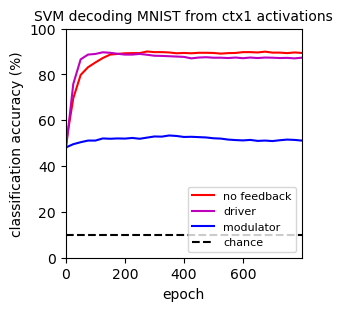

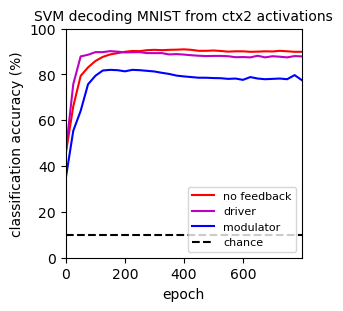

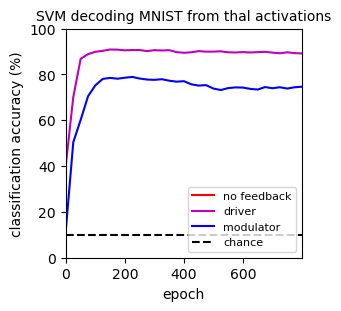

In [83]:
for layer in accuracies.keys():
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    for model_idx, model_selected in enumerate(accuracies[layer].keys()):
        ax.plot(accuracies[layer][model_selected].keys(), np.array(list(accuracies[layer][model_selected].values())) * 100, c=colours[model_idx], label=model_selected)
    ax.axhline(10, ls="--", c="k", label="chance")
    ax.set_title(f"SVM decoding MNIST from {layer} activations")
    ax.set_ylabel("classification accuracy (%)")
    ax.set_xlabel("epoch")
    ax.set_ylim(0, 100)
    ax.set_xlim(list(accuracies[layer][model_selected].keys())[0], list(accuracies[layer][model_selected].keys())[-1])
    ax.legend(loc="lower right")
    fig.savefig(Path(save_path, f"svm_decoding_{layer}.png"))

Decoding cue side

In [ ]:
# inference on full test set using models trained to various epochs
epochs_range = np.arange(0, 800, 25)
epochs_range = np.append(epochs_range, [799])
activations = {}
for model_selected in models_selected:
    activations[model_selected] = {}

    # instantiate model
    model = CTCNet(input_size=results[model_selected]["hyperparams"]["input_size"],
                   output_size=results[model_selected]["hyperparams"]["output_size"],
                   ctx_layer_size=results[model_selected]["hyperparams"]["ctx_layer_size"],
                   thal_layer_size=results[model_selected]["hyperparams"]["thal_layer_size"],
                   thalamocortical_type=results[model_selected]["hyperparams"]["thalamocortical_type"],
                   thal_reciprocal=results[model_selected]["hyperparams"]["thal_reciprocal"],
                   thal_to_readout=results[model_selected]["hyperparams"]["thal_to_readout"], 
                   thal_per_layer=results[model_selected]["hyperparams"]["thal_per_layer"])
    
    for epoch in epochs_range:
        activations[model_selected][epoch] = {}

        # get model trained to specified epoch
        weights = results[model_selected]["state_dicts"][epoch]

        # set model weights
        model.load_state_dict(weights)

        # Register hooks for specific layers
        hook_handles = []
        activations_this_epoch = {}
        for name, layer in model.named_modules():
            handle = layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activations_this_epoch))
            hook_handles.append(handle)
        
        # inference (on full dataset)
        with torch.no_grad():
            
            y_est_logits = model(torch.Tensor(X_all_reshaped))
            y_est_prob = softmax(y_est_logits.detach().numpy())
            y_est = np.argmax(y_est_prob, axis=1)

            # Remove hooks after use
            for handle in hook_handles:
                handle.remove()
        
        activations[model_selected][epoch] = copy.deepcopy(activations_this_epoch)

In [ ]:
# define readable names for connections of interest
# NOTE: always double check these before usimng
# readable_names = {"ctx1": list(activations["ff_MNIST"][0].keys())[2],
#                   "ctx2": list(activations["ff_MNIST"][0].keys())[5],
#                   "ctx_readout": list(activations["ff_MNIST"][0].keys())[7]
#                 #   "thal": list(activations["ff_MNIST"][0].keys())[10], # TODO: figure out why thal layer not showing up in activations dict
# }
readable_layer_idxs = {"ctx1": 2,
                       "ctx2": 5,
                       "ctx_readout": 7,
                       "thal": 10, # TODO: figure out why thal layer not showing up in activations dict
}

In [ ]:
# activations decoding analysis 
layers_selected = ["ctx1", "ctx2", "thal"]
train_test_split = 0.8
accuracies = {}
for layer_selected in layers_selected:
    accuracies[layer_selected] = {}
    for model_selected in models_selected:
        print(f"Decoding for {layer_selected}, {model_selected}")
        accuracies[layer_selected][model_selected] = {}
        for epoch in epochs_range:
            
            try:

                # select layer activations to decode from
                features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer_selected]]].detach().numpy()

                # split into train and test set
                test_cutoff = int(len(features) * train_test_split)
                X_train = features[:test_cutoff, :]
                X_test = features[test_cutoff:, :]
                # y_train = y_all_reshaped[:test_cutoff]
                # y_test = y_all_reshaped[test_cutoff:]
                y_train = sides_encoded[:test_cutoff]
                y_test = sides_encoded[test_cutoff:]
            
                print(f"{X_test.shape=}")
                print(f"{y_test.shape=}")

                # TODO: perform cross-validation
                # TODO: try replacing with linear classifier
                
                # # train SVM classifier
                # clf = svm.SVC(kernel="linear")
                # clf.fit(X_train, y_train)

            #     # test SVM classifier
            #     y_pred = clf.predict(X_test)
                
            #     # compute classification accuracy
            #     correct = 0
            #     for samp_idx in range(y_pred.shape[0]):
            #         if y_pred[samp_idx] == y_test[samp_idx]:
            #             correct += 1
            #     accuracy = correct / y_pred.shape[0]
            #     print(f"epoch: {epoch}, accuracy: {accuracy * 100:.2f}%")

            #     accuracies[layer_selected][model_selected][epoch] = accuracy
            except:
                accuracies[layer_selected][model_selected][epoch] = np.nan


Decoding for ctx1, no feedback
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_test.shape=(1396, 128)
y_test.shape=(1422,)
X_t

In [ ]:
# save decoding accuracies
with open(Path(save_path, "svm_decoding_side_acc.pkl"), "wb") as handle:
    pickle.dump(accuracies, handle)

In [80]:
# load decoding accuracies if don't want to re-run
with open(Path(save_path, "svm_decoding_side_acc.pkl"), "rb") as handle:
    accuracies = pickle.load(handle)

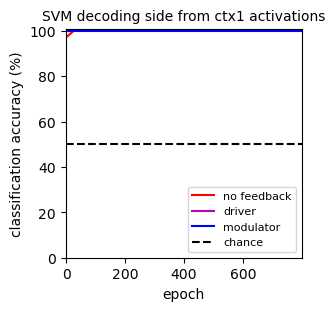

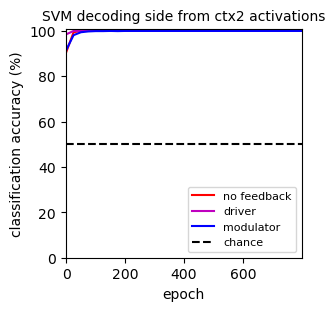

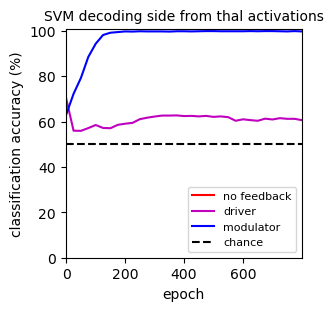

In [81]:
for layer in accuracies.keys():
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    for model_idx, model_selected in enumerate(accuracies[layer].keys()):
        ax.plot(accuracies[layer][model_selected].keys(), np.array(list(accuracies[layer][model_selected].values())) * 100, c=colours[model_idx], label=model_selected)
    ax.axhline(50, ls="--", c="k", label="chance")
    ax.set_title(f"SVM decoding side from {layer} activations")
    ax.set_ylabel("classification accuracy (%)")
    ax.set_xlabel("epoch")
    ax.set_ylim(0, 101)
    ax.set_xlim(list(accuracies[layer][model_selected].keys())[0]-1, list(accuracies[layer][model_selected].keys())[-1])
    ax.legend(loc="lower right")
    fig.savefig(Path(save_path, f"svm_decoding_side_{layer}.png"))

Activations by class ID

In [ ]:
sides_encoded.shape

(7002,)

In [54]:
y_all_reshaped.shape

(6976,)

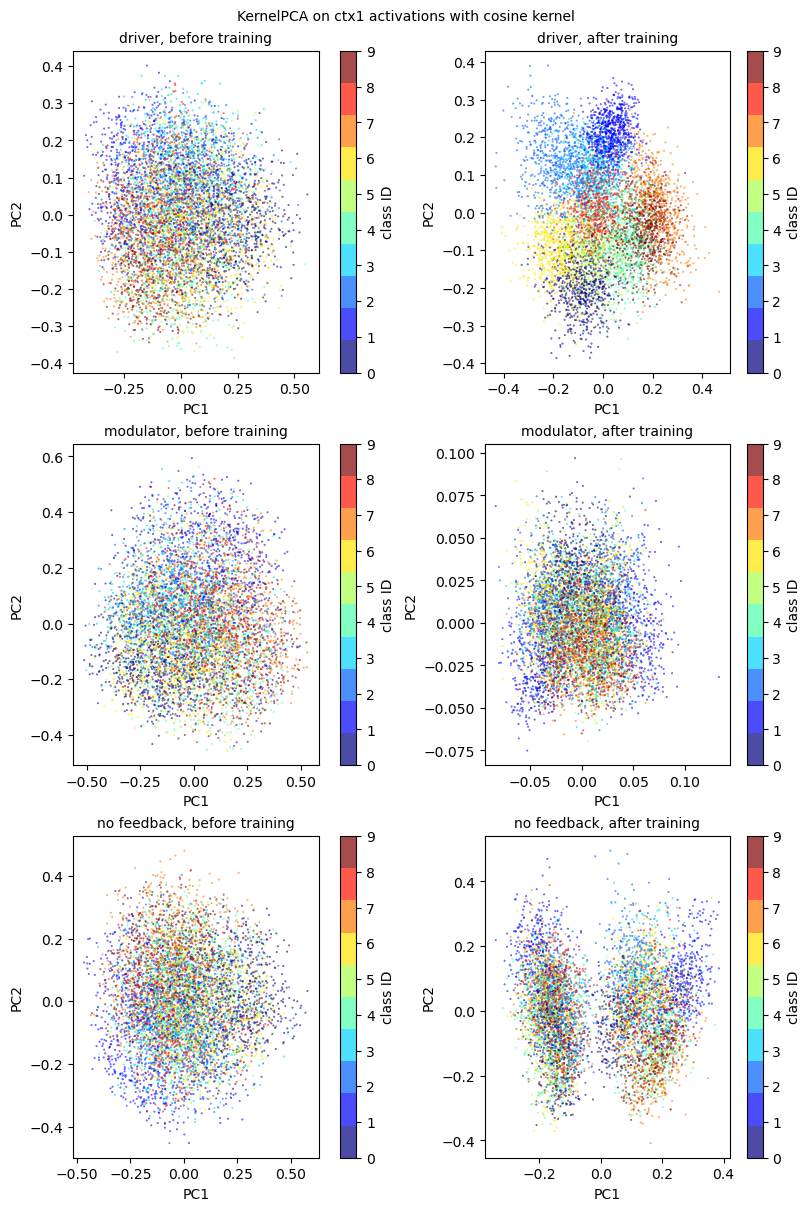

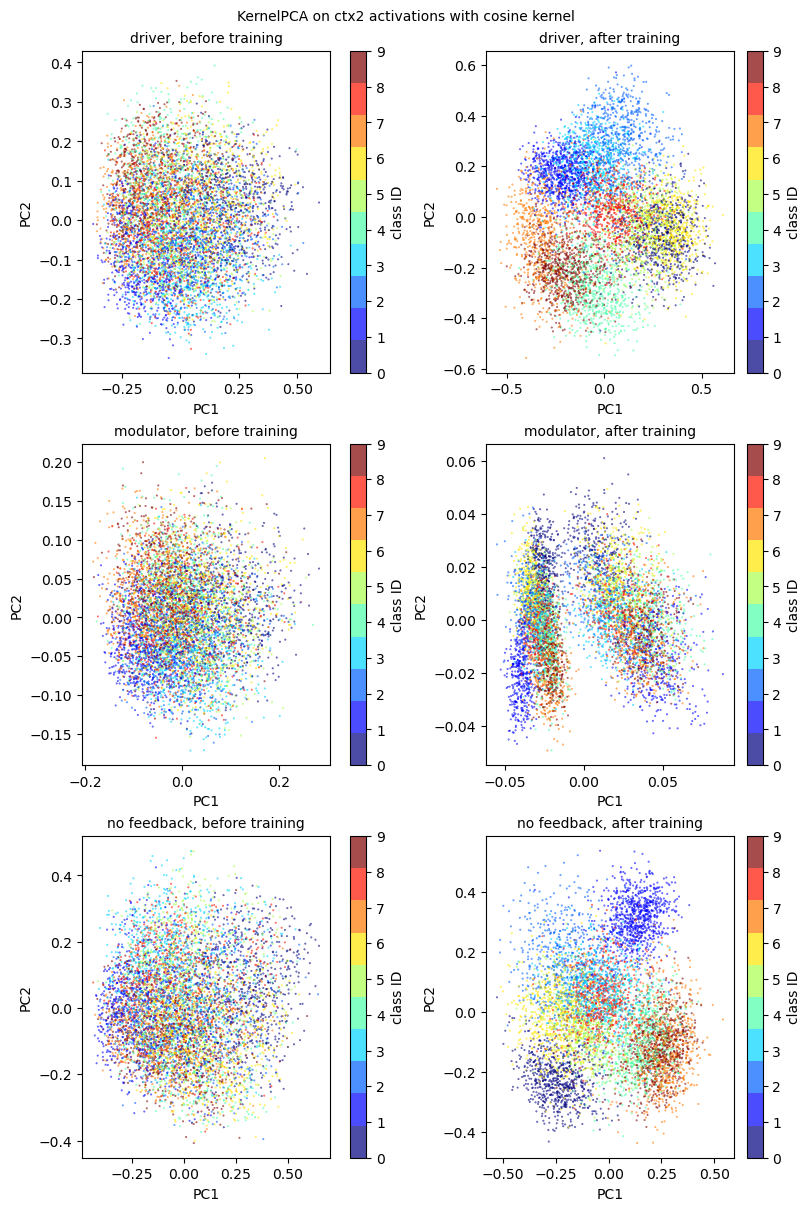

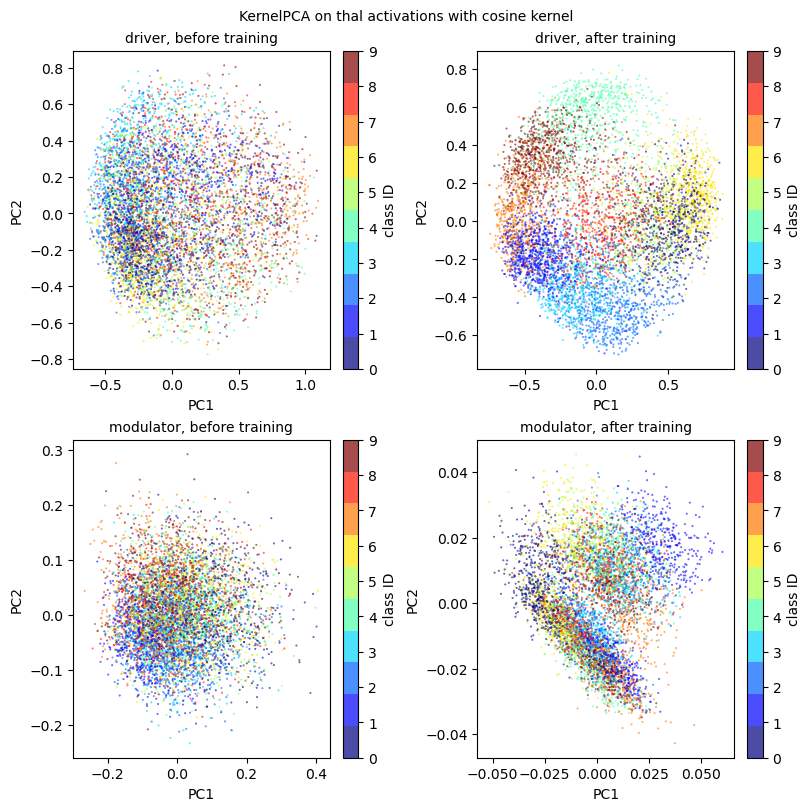

In [84]:
# activations analysis
reduction_method = "KernelPCA"
kernel = "cosine"
epochs = {"before training": 0,
          "after training": 799}

# generate colourmap
jet_cmap = plt.colormaps["jet"]  
N = 10
colors = jet_cmap(np.linspace(0, 1, N)) 
discrete_cmap = mcolors.ListedColormap(colors)

for layer in accuracies.keys():
    
    if layer == "thal":
        model_list = ["driver", "modulator"]
    else:
        model_list = ["driver", "modulator", "no feedback"]

    fig, ax = plt.subplots(len(model_list), len(epochs), figsize=(4 * len(epochs), 4 * len(model_list)), layout="constrained")

    for model_idx, model_selected in enumerate(model_list):

        for epoch_idx, (epoch_name, epoch) in enumerate(epochs.items()):
            
            features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()
        
            if reduction_method == "PCA":
                pca = PCA(n_components=2)
                activations_2d = pca.fit_transform(features)
                title = f"{reduction_method} on {layer} activations"
                save_tag = "pca"
            elif reduction_method == "KernelPCA":
                pca_transformer = KernelPCA(n_components=2, kernel=kernel)
                activations_2d = pca_transformer.fit_transform(features)
                title = f"{reduction_method} on {layer} activations with {kernel} kernel"
                save_tag = "kernel_pca"

            scatter = ax[model_idx, epoch_idx].scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_all_reshaped, cmap=discrete_cmap, alpha=0.7, s=0.2)
            plt.colorbar(scatter, label="class ID")
            
            ax[model_idx, epoch_idx].set_title(f"{model_selected}, {epoch_name}")
            ax[model_idx, epoch_idx].set_xlabel("PC1")
            ax[model_idx, epoch_idx].set_ylabel("PC2")

    fig.suptitle(title)
    fig.savefig(Path(save_path, f"{save_tag}_{layer}_activations_prepostlearning.png"))

In [51]:
sides_encoded.shape

(7002,)

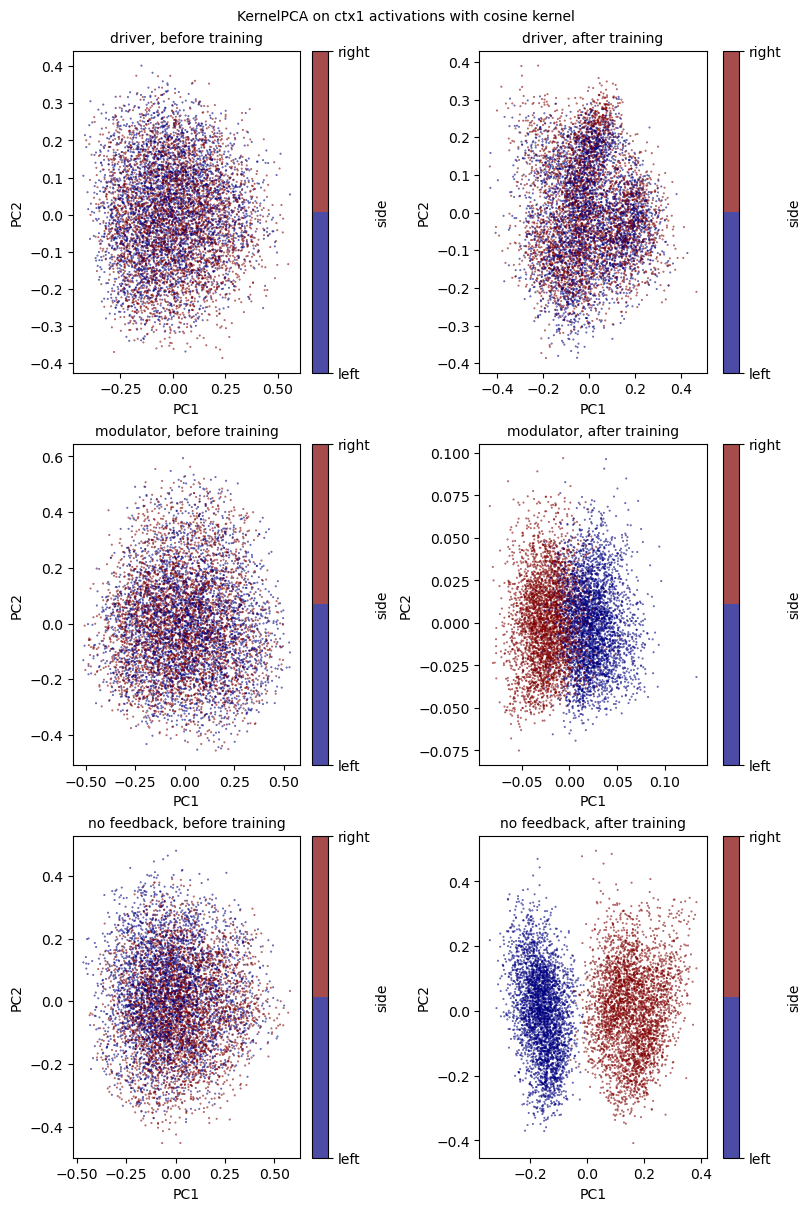

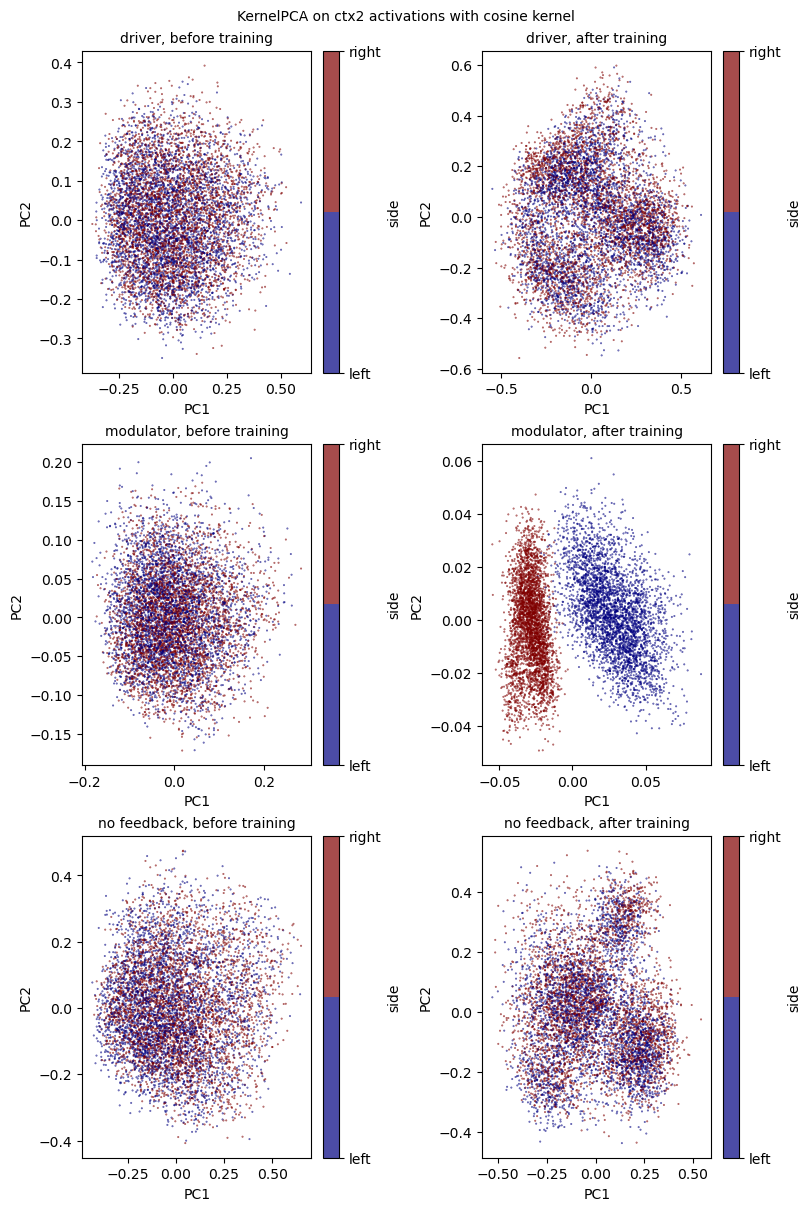

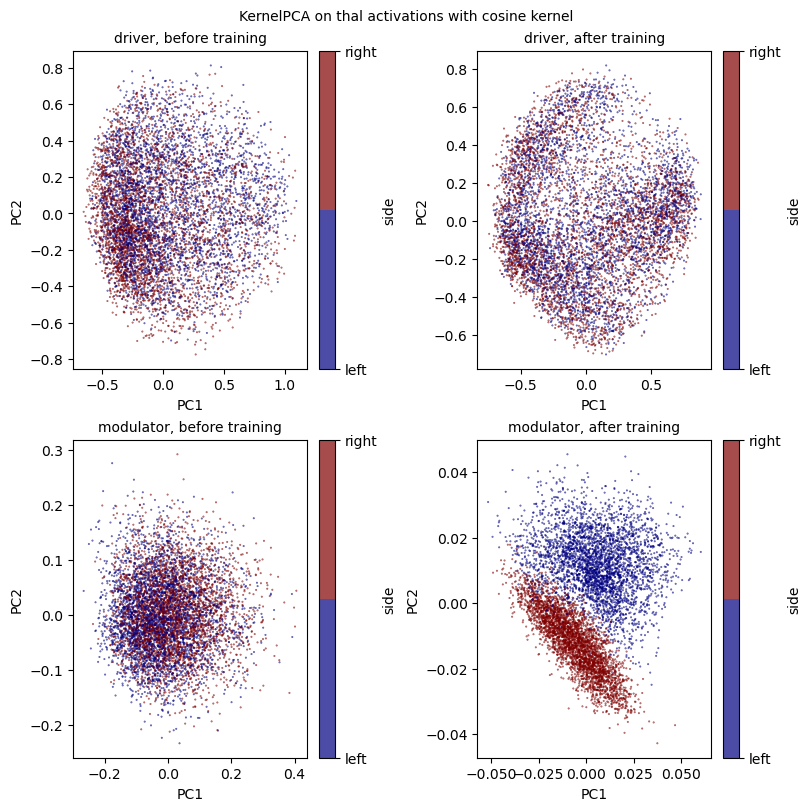

In [76]:
# activations analysis
reduction_method = "KernelPCA"
kernel = "cosine"
epochs = {"before training": 0,
          "after training": 799}

# generate colourmap
jet_cmap = plt.colormaps["jet"]  
N = 2
colors = jet_cmap(np.linspace(0, 1, N)) 
discrete_cmap = mcolors.ListedColormap(colors)

for layer in accuracies.keys():
    
    if layer == "thal":
        model_list = ["driver", "modulator"]
    else:
        model_list = ["driver", "modulator", "no feedback"]

    fig, ax = plt.subplots(len(model_list), len(epochs), figsize=(4 * len(epochs), 4 * len(model_list)), layout="constrained")

    for model_idx, model_selected in enumerate(model_list):

        for epoch_idx, (epoch_name, epoch) in enumerate(epochs.items()):
            
            features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()
        
            if reduction_method == "PCA":
                pca = PCA(n_components=2)
                activations_2d = pca.fit_transform(features)
                title = f"{reduction_method} on {layer} activations"
                save_tag = "pca_side"
            elif reduction_method == "KernelPCA":
                pca_transformer = KernelPCA(n_components=2, kernel=kernel)
                activations_2d = pca_transformer.fit_transform(features)
                title = f"{reduction_method} on {layer} activations with {kernel} kernel"
                save_tag = "kernel_pca_side"

            scatter = ax[model_idx, epoch_idx].scatter(activations_2d[:, 0], activations_2d[:, 1], c=sides_encoded, cmap=discrete_cmap, alpha=0.7, s=0.2)
            cbar = plt.colorbar(scatter, label="side")
            cbar.set_ticks([0, 1])  # Adjust according to your encoding
            cbar.set_ticklabels(["left", "right"])

            ax[model_idx, epoch_idx].set_title(f"{model_selected}, {epoch_name}")
            ax[model_idx, epoch_idx].set_xlabel("PC1")
            ax[model_idx, epoch_idx].set_ylabel("PC2")

    fig.suptitle(title)
    fig.savefig(Path(save_path, f"{save_tag}_{layer}_activations_prepostlearning.png"))

Activations by cue side

In [ ]:
# activations analysis
reduction_method = "KernelPCA"
kernel = "cosine"
epochs = {"before training": 0,
          "after training": 799}

# generate colourmap
jet_cmap = plt.colormaps["jet"]  
N = 2
colors = jet_cmap(np.linspace(0, 1, N)) 
discrete_cmap = mcolors.ListedColormap(colors)

for layer in accuracies.keys():
    
    if layer == "thal":
        model_list = ["driver", "modulator"]
    else:
        model_list = ["driver", "modulator", "no feedback"]

    fig, ax = plt.subplots(len(model_list), len(epochs), figsize=(4 * len(epochs), 4 * len(model_list)), layout="constrained")

    for model_idx, model_selected in enumerate(model_list):

        for epoch_idx, (epoch_name, epoch) in enumerate(epochs.items()):
            
            features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()
        
            if reduction_method == "PCA":
                pca = PCA(n_components=2)
                activations_2d = pca.fit_transform(features)
                title = f"{reduction_method} on {layer} activations"
                save_tag = "pca"
            elif reduction_method == "KernelPCA":
                pca_transformer = KernelPCA(n_components=2, kernel=kernel)
                activations_2d = pca_transformer.fit_transform(features)
                title = f"{reduction_method} on {layer} activations with {kernel} kernel"
                save_tag = "kernel_pca"

            scatter = ax[model_idx, epoch_idx].scatter(activations_2d[:, 0], activations_2d[:, 1], c=sides, cmap=discrete_cmap, alpha=0.7, s=0.2)
            plt.colorbar(scatter, label="cue side")
            
            ax[model_idx, epoch_idx].set_title(f"{model_selected}, {epoch_name}")
            ax[model_idx, epoch_idx].set_xlabel("PC1")
            ax[model_idx, epoch_idx].set_ylabel("PC2")

    fig.suptitle(title)
    fig.savefig(Path(save_path, f"{save_tag}_{layer}_activations_prepostlearning.png"))

Weight decomposition

In [ ]:
# define readable names for connections of interest
# NOTE: always double check these before using
readable_weight_idxs = {"input_to_ctx1": {"no feedback": 2,
                                          "driver": 8,
                                          "modulator": 8},
                        "ctx1_to_ctx2": {"no feedback": 4,
                                          "driver": 10,
                                          "modulator": 10},
                        "thal_to_ctx1": {"no feedback": None,
                                          "driver": 2,
                                          "modulator": 2},
                        "thal_to_ctx2": {"no feedback": None,
                                          "driver": 4,
                                          "modulator": 4}}

In [ ]:
# weight decomposition analysis
weights_selected = ["input_to_ctx1", "ctx1_to_ctx2", "thal_to_ctx1", "thal_to_ctx2"]
svds = {}
for weights_select in weights_selected:
    svds[weights_select] = {}
    for model_selected in models_selected:
        svds[weights_select][model_selected] = {}
        for epoch in epochs_range:

            if (model_selected == "no feedback") and (weights_select in ["thal_to_ctx1", "thal_to_ctx2"]):

                svds[weights_select][model_selected][epoch] = None

            else:

                # get weights in forward pass direction and compute spectral measures
                weights = results[model_selected]["state_dicts"][epoch][list(results[model_selected]["state_dicts"][epoch].keys())[readable_weight_idxs[weights_select][model_selected]]]

                # SVD on weights
                U, s, Vh = svd(weights)
                s_norm = s / np.sum(s)
                
                # compute spectral metrics
                spectral_entropy = entropy(s_norm)
                spectral_norm = np.max(s)
                condition_number = np.max(s) / np.min(s)
                
                # store
                svds[weights_select][model_selected][epoch] = {"U": U,
                                                            "s": s,
                                                            "Vh": Vh,
                                                            "s_norm": s_norm,
                                                            "spectral_entropy": spectral_entropy,
                                                            "spectral_norm": spectral_norm,
                                                            "condition_number": condition_number}

                # print(f"{weights.shape=}")
                # print(f"{Vh.shape=}")

In [ ]:
weights_select = "thal_to_ctx1"
model_select = "driver"
epochs = [0, 799]

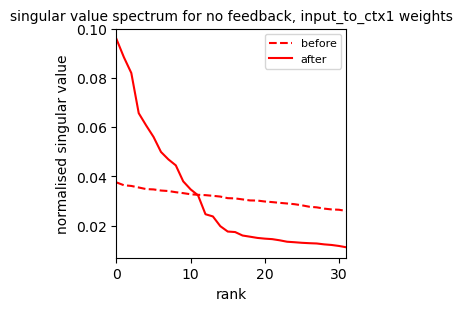

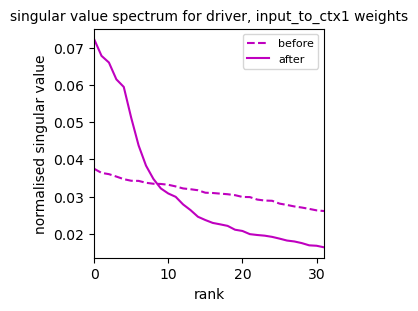

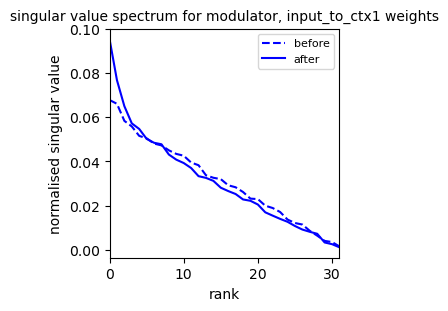

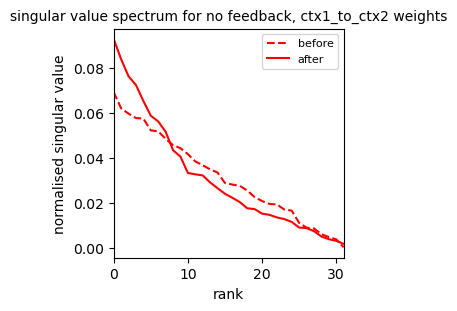

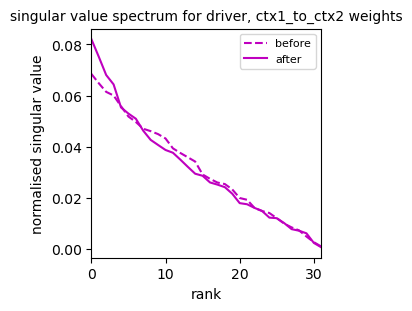

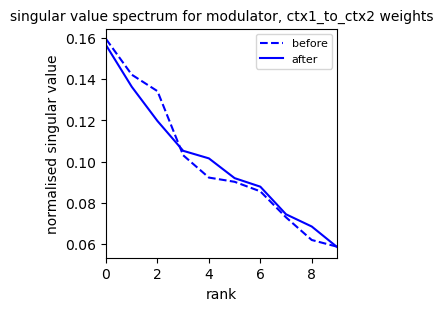

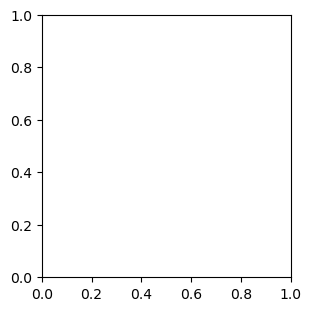

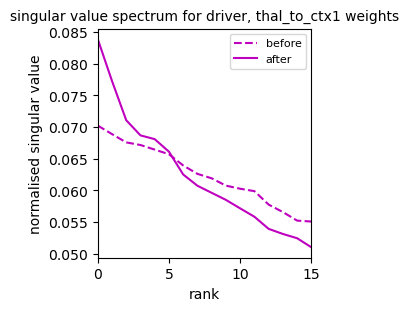

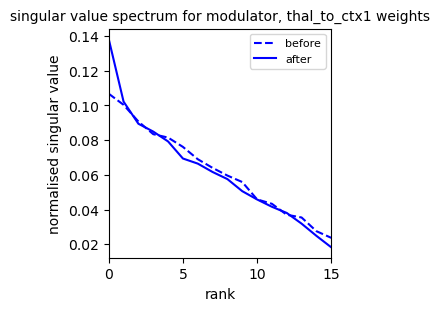

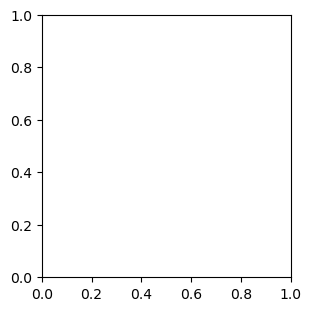

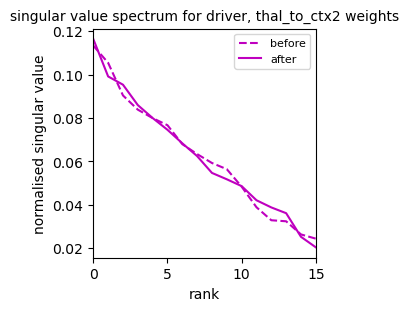

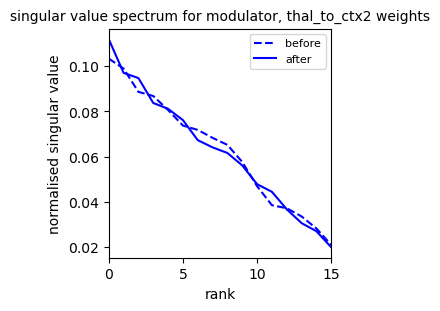

In [ ]:
for weights_select in weights_selected:
    for model_idx, model_select in enumerate(models_selected):
        try:
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))
            epochs = {"before": 0,
                    "after": 799}
            c = colours[model_idx]
            linestyles = ["--", "-"]
            for epoch_idx, (epoch_name, epoch) in enumerate(epochs.items()):
                ax.plot(svds[weights_select][model_select][epoch]["s_norm"], c=c, label=epoch_name, ls=linestyles[epoch_idx])
            ax.set_title(f"singular value spectrum for {model_select}, {weights_select} weights")
            ax.set_ylabel("normalised singular value")
            ax.set_xlabel("rank")
            ax.set_xlim(0, len(svds[weights_select][model_select][epoch]["s_norm"])-1)
            ax.legend()
            fig.savefig(Path(save_path, f"sv_spectrum_{model_select}_{weights_select}_prepostlearning.png"))
        except:
            pass

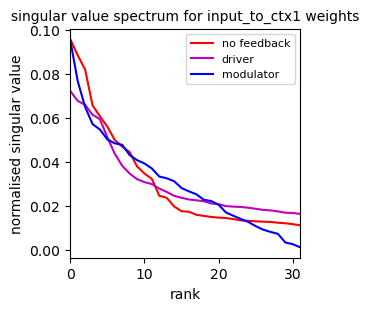

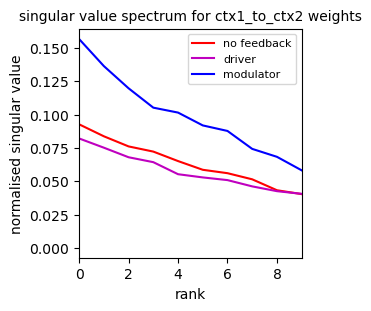

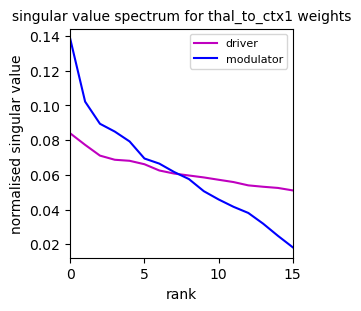

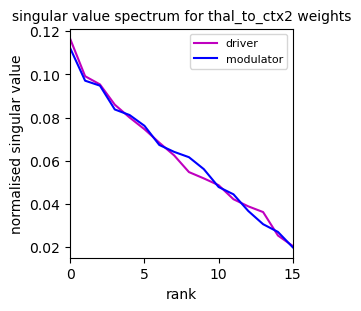

In [ ]:
for weights_select in weights_selected:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    for model_idx, model_select in enumerate(models_selected):
        try:
            ax.plot(svds[weights_select][model_select][epoch]["s_norm"], c=colours[model_idx], label=model_select)
            ax.set_title(f"singular value spectrum for {weights_select} weights")
            ax.set_ylabel("normalised singular value")
            ax.set_xlabel("rank")
            ax.set_xlim(0, len(svds[weights_select][model_select][epoch]["s_norm"])-1)
        except:
            pass
    ax.legend(loc="upper right")
    fig.savefig(Path(save_path, f"norm_sv_spectrum_{model_select}_{weights_select}.png"))

In [ ]:
# plot spectral entropy for thal to ctx1 and thal to ctx2 weights for different models


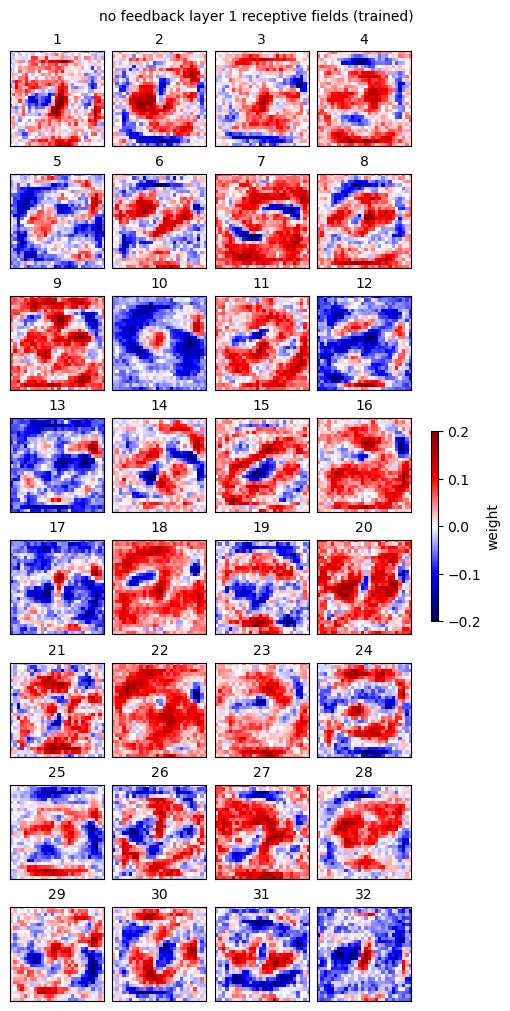

In [ ]:
model_selected = "no feedback"
# receptive field analysis
cmap = cm.get_cmap("seismic")
clims = [-0.2, 0.2]
epoch_name = "trained"
epoch = 799
fig, ax = plt.subplots(8, 4, figsize=(5, 10), layout="constrained")

for neuron_id in range(32):

    row_idx = neuron_id // 4
    col_idx = neuron_id % 4

    input_layer_weights = results[model_selected]["state_dicts"][epoch][list(results[model_selected]["state_dicts"][epoch].keys())[readable_weight_idxs["input_to_ctx1"][model_selected]]]


    weights_this_neuron = get_neuron_weights(weights=input_layer_weights,
                                             neuron_id=neuron_id,
                                             shape=(28, 28))
    plot_receptive_field(weights=weights_this_neuron,
                         ax=ax[row_idx, col_idx],
                         cmap=cmap,
                         clims=clims,
                         title=neuron_id+1)

psm = ax[0, 0].pcolormesh(weights_this_neuron, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
cbar = fig.colorbar(psm, ax=ax, shrink=0.2, aspect=30)
cbar.set_label("weight")
cbar.ax.xaxis.set_ticks_position('top') 
cbar.ax.xaxis.set_label_position('top')
fig.suptitle(f"{model_selected} layer 1 receptive fields ({epoch_name})")
fig.savefig(Path(save_path, f"norm_sv_spectrum_{model_select}_{weights_select}.png"))

Ablation analysis

In [ ]:
# accuracy with ablated feedback connections

In [ ]:
# activations with ablated feedback